In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys
import cv2
from tqdm import tqdm
import seaborn as sns

import tensorflow as tf
import keras
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet
from keras.layers.pooling import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/Users/jinsakuma/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jinsakuma/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jinsakuma/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jinsakuma/anaconda3/lib/python3.6/sit

In [2]:
ROWS = 224
COLS = 224
CHANNELS = 3

TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'

In [14]:
train_list = []
test_list = []
labels = []

for name in tqdm(os.listdir(TRAIN_DIR)):
    path = TRAIN_DIR+name
    img = cv2.imread(path)
    resized = cv2.resize(img, (ROWS, COLS))
    train_list.append(resized)
    
    if 'dog' in name:
        labels.append(0)
    else:
        labels.append(1)
    
for name in tqdm(os.listdir(TEST_DIR)):
    path = TEST_DIR+name
    img = cv2.imread(path)
    
    resized = cv2.resize(img, (ROWS, COLS))
    test_list.append(resized)
    
train = np.asarray(train_list)
test = np.asarray(test_list)

100%|██████████| 100/100 [00:00<00:00, 126.26it/s]


Train: (2000, 224, 224, 3)
Test: (100, 224, 224, 3)


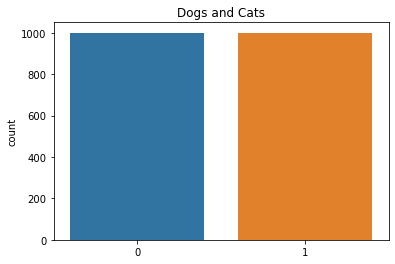

In [4]:
print("Train: {}".format(train.shape))
print("Test: {}".format(test.shape))

sns.countplot(labels)
plt.title('Dogs and Cats')

labels = to_categorical(labels)

In [6]:
num_classes = 2

base_model = MobileNet(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

# 全結合層の新規構築
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)
print("{}層".format(len(model.layers)))

/Users/jinsakuma/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


90層


In [7]:
# 72層までfreeze
for layer in model.layers[:72]:
    layer.trainable = False

    # Batch Normalization の freeze解除
    if "bn" in layer.name:
        layer.trainable = True

#73層以降、学習させる
for layer in model.layers[72:]:
    layer.trainable = True

# layer.trainableの設定後にcompile
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

In [8]:
# 学習を開始します。
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1
)

n_epoch = 10
batch_size = 128

hist = model.fit(train,
                        labels,
                        epochs=n_epoch,
                        validation_split=0.2,
                        callbacks = [early_stopping],
                        verbose=1,
                        batch_size=batch_size)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 290s 182ms/step - loss: 0.3142 - acc: 0.9056 - val_loss: 0.1219 - val_acc: 0.9675
Epoch 2/10
1600/1600 [==============================] - 285s 178ms/step - loss: 0.0566 - acc: 0.9869 - val_loss: 0.1102 - val_acc: 0.9750
Epoch 3/10
1600/1600 [==============================] - 285s 178ms/step - loss: 0.0184 - acc: 0.9950 - val_loss: 0.3305 - val_acc: 0.9575
Epoch 4/10
1600/1600 [==============================] - 295s 184ms/step - loss: 0.0247 - acc: 0.9950 - val_loss: 0.4643 - val_acc: 0.9425
Epoch 5/10
1600/1600 [==============================] - 304s 190ms/step - loss: 0.0196 - acc: 0.9962 - val_loss: 0.7926 - val_acc: 0.9200
Epoch 6/10
1600/1600 [==============================] - 317s 198ms/step - loss: 0.0112 - acc: 0.9994 - val_loss: 1.4718 - val_acc: 0.8725
Epoch 7/10
1600/1600 [==============================] - 281s 175ms/step - loss: 0.0076 - acc: 0.9994 - val_loss: 0.8810 - val

In [12]:
model.save('./model/model.h5')

In [13]:
loaded_model = load_model('./model/model.h5')

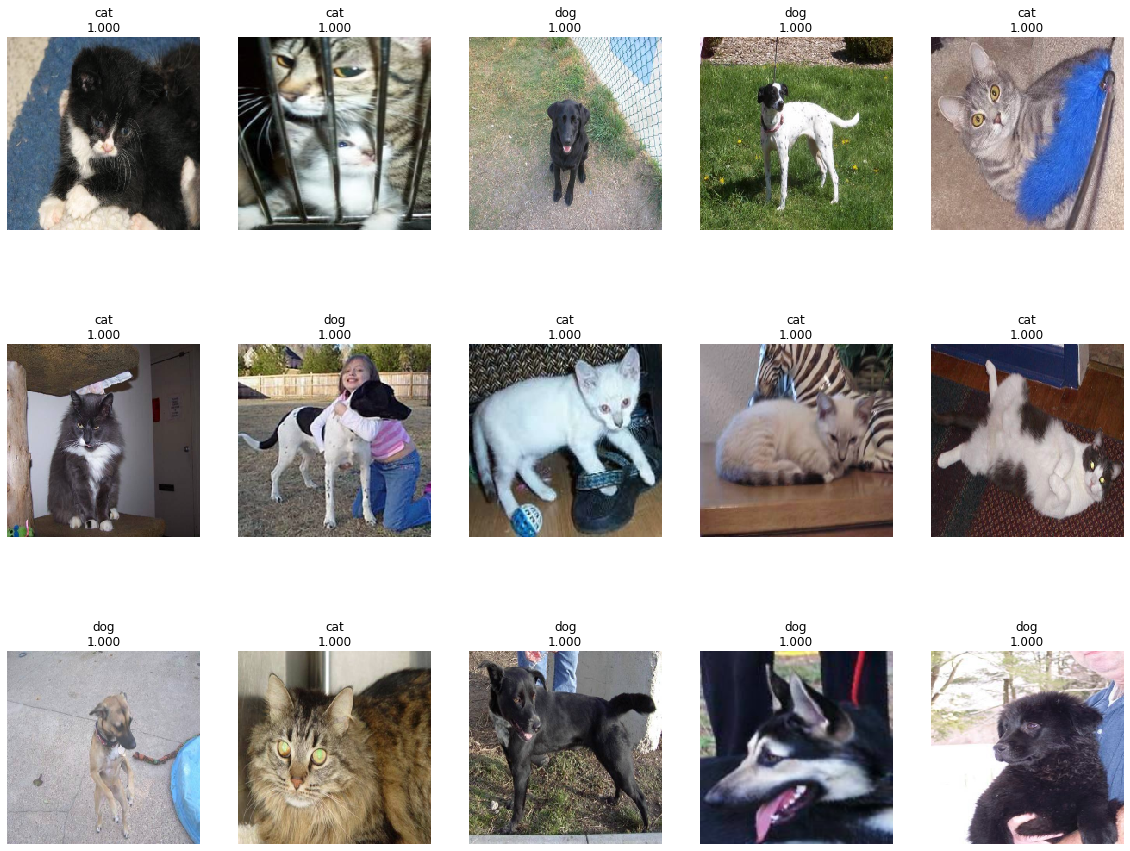

In [27]:
classes = ["dog", "cat"]

# testデータ15件の予測ラベル
pred_classes = np.argmax(loaded_model.predict(test[0:15]), axis = 1)

# testデータ15件の予測確率
pred_probs = np.max(model.predict(test[0:15]), axis = 1)
pred_probs = ['{:.3f}'.format(i) for i in pred_probs]

# testデータ15件の画像と予測ラベル・予測確率を出力
plt.figure(figsize = (20, 16))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.axis("off")
    
    plt.title(classes[pred_classes[i]] + '\n' + pred_probs[i])
    plt.imshow(test[i])
plt.show()